<a href="https://colab.research.google.com/github/edrakopo/MLAlgorithms/blob/master/Copy_of_xgboost_quantile_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Quantile Regression with Gradient Boosting Regressor](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html)

This notebook is based on work [Regression prediction intervals with XGBOOST](https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b)



In [124]:
#@title Imports and Utilities

#standard
import numpy as np
np.random.seed(1) #fix seed for notebook
import pandas as pd
import scipy

#ML
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

#utils
from functools import partial

#plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

#Read data file
infile = "/Users/edrakopo/Desktop/vars_Ereco.csv"  
filein = open(str(infile))
print("evts for training in: ",filein)
  
E_threshold = 2.
df00=pd.read_csv(filein)
df0=df00[['totalPMTs','totalLAPPDs','TrueTrackLengthInWater','trueKE','diffDirAbs','TrueTrackLengthInMrd','recoDWallR','recoDWallZ','dirX','dirY','dirZ','vtxX','vtxY','vtxZ','DNNRecoLength']]
print(df0.head())
print(df0.describe())
dfsel=df0#.loc[df0['neutrinoE'] < E_threshold]

def generate_data():

  """
  Generates data sample as seen in "Prediction Intervals for Gradient Boosting Regression"
  (https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html)
  """
  np.random.seed(1)
  f = lambda u: u*np.sin(u)

  #  First the noiseless case
  X_train = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
  X_train = X_train.astype(np.float32)

  # Observations
  y_train = f(X_train).ravel()
  dy = 1.5 + 1.0 * np.random.random(y_train.shape)
  noise = np.random.normal(0, dy)
  y_train += noise
  y_train = y_train.astype(np.float32)

  # Mesh the input space for evaluations of the real function, the prediction and
  # its MSE
  X_test = np.atleast_2d(np.linspace(0, 10.0, 1000)).T
  X_test = X_test.astype(np.float32)
  y_test = f(X_test).ravel()
  
def get_data():  
  dfsel_n = pd.DataFrame([ dfsel['DNNRecoLength']/600., dfsel['TrueTrackLengthInMrd']/100., dfsel['diffDirAbs']/2., dfsel['recoDWallR'], dfsel['recoDWallZ'], dfsel['totalLAPPDs']/500., dfsel['totalPMTs']/200., dfsel['vtxX']/150., dfsel['vtxY']/200., dfsel['vtxZ']/150. ]).T
  print("chehck normalisation: ", dfsel_n.head())
    
  arr_hi_E0 = np.array(dfsel_n[['DNNRecoLength','TrueTrackLengthInMrd','diffDirAbs','recoDWallR','recoDWallZ','totalLAPPDs','totalPMTs','vtxX','vtxY','vtxZ']])
  arr3_hi_E0 = np.array(dfsel[['trueKE']])  
  
  #---- random split of events ----
  rnd_indices = np.random.rand(len(arr_hi_E0)) < 1. #< 0.50
  #--- select events for training/test:
  arr_hi_E0B = arr_hi_E0[rnd_indices] 
  arr2_hi_E_n = arr_hi_E0B #.reshape(arr_hi_E0B.shape + (-1,))
  arr3_hi_E = arr3_hi_E0[rnd_indices] 
   
  #--- select 70% of sample for training and 30% for testing:
  offset = int(arr2_hi_E_n.shape[0] * 0.7) 
  X_train, y_train = arr2_hi_E_n[:offset], arr3_hi_E[:offset].reshape(-1)  # train sample
  X_test, y_test   = arr2_hi_E_n[offset:], arr3_hi_E[offset:].reshape(-1)  # test sample
 
  print("train shape: ", X_train.shape," label: ",y_train.shape)
  print("test shape: ", X_test.shape," label: ",y_test.shape)

  return X_train,y_train,X_test,y_test

def collect_prediction(X_train,y_train,X_test,y_test,estimator,alpha,model_name):
  estimator.fit(X_train,y_train)
  y_pred = estimator.predict(X_test)
  print( "{model_name} alpha = {alpha:.2f},score = {score:.1f}".format(model_name=model_name, alpha=alpha , score= XGBQuantile.quantile_score(y_test, y_pred, alpha)) )

  return y_pred
def plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower):


  #plt.plot(X_test,y_test, 'g:', label=u'$f(x) = x\,\sin(x)$')
  plt.plot(X_train,y_train, 'b.', markersize=10, label=u'Observations')
  plt.plot(X_test, y_pred, 'r-', label=u'Prediction')
  plt.plot(X_test, y_upper, 'k-')
  plt.plot(X_test, y_lower, 'k-')
  plt.fill(np.concatenate([X_test, X_test[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
  plt.xlabel('$x$')
  plt.ylabel('$f(x)$')
  plt.ylim(-10 , 20)
  plt.legend(loc='upper left')

    
def makeplots_result(y_test, y_pred, y_med, y_upper, y_lower):

    fig = plt.figure(figsize=(10, 10))
    #plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
    plt.plot(y_test, y_pred, "b.", markersize=10, label="Predictions")
    plt.plot(y_test, y_med, "g.", label="Predicted median")
    plt.plot(y_test, y_pred, "r.", label="Predicted mean")
    #plt.plot(y_test, y_upper, "k.")
    #plt.plot(y_test, y_lower, "k.")
    plt.fill_between(y_test.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval")
    plt.xlabel("$E_{muon}$")
    plt.ylabel("$E_{reco}$")
    plt.ylim(400, 1400)
    plt.xlim(400, 1400)
    plt.xticks(np.arange(400, 1400, step=100))
    plt.yticks(np.arange(400, 1400, step=100))
    plt.legend(loc="upper left")
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
    plt.show()

evts for training in:  <_io.TextIOWrapper name='/Users/edrakopo/Desktop/vars_Ereco.csv' mode='r' encoding='UTF-8'>
   totalPMTs  totalLAPPDs  TrueTrackLengthInWater   trueKE  diffDirAbs  \
0       20.0         85.0                 171.103  714.504       0.000   
1       29.0        133.0                 218.367  641.529       0.089   
2       10.0         25.0                 134.043  455.073       0.200   
3       32.0        133.0                 235.234  779.161       0.262   
4       19.0        238.0                 191.331  559.195       0.194   

   TrueTrackLengthInMrd  recoDWallR  recoDWallZ   dirX   dirY   dirZ    vtxX  \
0                23.442       0.278       0.995 -0.000 -0.000  1.000  97.739   
1                 3.839       0.417       0.998  0.093 -0.104  0.990 -52.263   
2                 3.659       0.362       0.719  0.092 -0.294  0.951  97.042   
3                17.895       0.506       0.878 -0.398  0.040  0.916  29.117   
4                 3.295       0.861     

# Fitting non-linear quantile and least squares regressors

Fit gradient boosting models trained with the quantile loss and alpha=0.05, 0.5, 0.95.

The models obtained for alpha=0.05 and alpha=0.95 produce a 90% confidence interval (95% - 5% = 90%).

The model trained with alpha=0.5 produces a regression of the median: on average, there should be the same number of target observations above and below the predicted values.

In [116]:
#Get data:
X_train,y_train,X_test,y_test = get_data()

chehck normalisation:     DNNRecoLength  TrueTrackLengthInMrd  diffDirAbs  recoDWallR  recoDWallZ  \
0       0.294275               0.23442      0.0000       0.278       0.995   
1       0.367642               0.03839      0.0445       0.417       0.998   
2       0.215585               0.03659      0.1000       0.362       0.719   
3       0.400168               0.17895      0.1310       0.506       0.878   
4       0.303958               0.03295      0.0970       0.861       0.882   

   totalLAPPDs  totalPMTs      vtxX      vtxY      vtxZ  
0        0.170      0.100  0.651593  0.004725 -0.337287  
1        0.266      0.145 -0.348420  0.001545 -0.478653  
2        0.050      0.050  0.646947  0.278085  0.040180  
3        0.266      0.160  0.194113 -0.120440 -0.462760  
4        0.476      0.095  0.070547  0.116670 -0.122540  
train shape:  (1530, 10)  label:  (1530,)
test shape:  (656, 10)  label:  (656,)


In [117]:
from sklearn.metrics import mean_pinball_loss, mean_squared_error

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

Notice that HistGradientBoostingRegressor is much faster than GradientBoostingRegressor starting with intermediate datasets (n_samples >= 10_000), which is not the case of the present example.

For the sake of comparison, we also fit a baseline model trained with the usual (mean) squared error (MSE).

In [118]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

In [119]:
y_pred = all_models["mse"].predict(X_test)
y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)
y_med = all_models["q 0.50"].predict(X_test)
print(y_pred[:10])
print(y_med[:10])
print(y_lower[:10])
print(y_upper[:10])

'''
DE_E = (y_test-y_pred)/y_test
print(DE_E[:10])
DE_E_lower = (y_test-y_lower)/y_test
print(DE_E_lower[:10])
DE_E_upper = (y_test-y_upper)/y_test
print(DE_E_upper[:10])
'''

[ 817.64164341  564.07822649  940.59959605  943.72910044  645.78025128
  766.18749473 1065.82647029 1055.41450647  714.069703    872.27328992]
[ 823.27410565  575.97408849  949.16382959  955.21677556  643.31740723
  739.0536606  1056.02958253 1045.03093608  734.12003169  886.82118209]
[755.52504517 533.09617888 847.37908404 868.06754408 615.20916618
 699.79048877 935.54622136 982.10993264 681.86051701 847.70172216]
[ 868.39781304  630.54595839  977.58567705 1010.63006044  689.92326028
  784.54212214 1106.19021655 1104.85302218  720.91675331  959.72497542]


'\nDE_E = (y_test-y_pred)/y_test\nprint(DE_E[:10])\nDE_E_lower = (y_test-y_lower)/y_test\nprint(DE_E_lower[:10])\nDE_E_upper = (y_test-y_upper)/y_test\nprint(DE_E_upper[:10])\n'

Plot the true conditional mean function f, the predictions of the conditional mean (loss equals squared error), the conditional median and the conditional 90% interval (from 5th to 95th conditional percentiles).

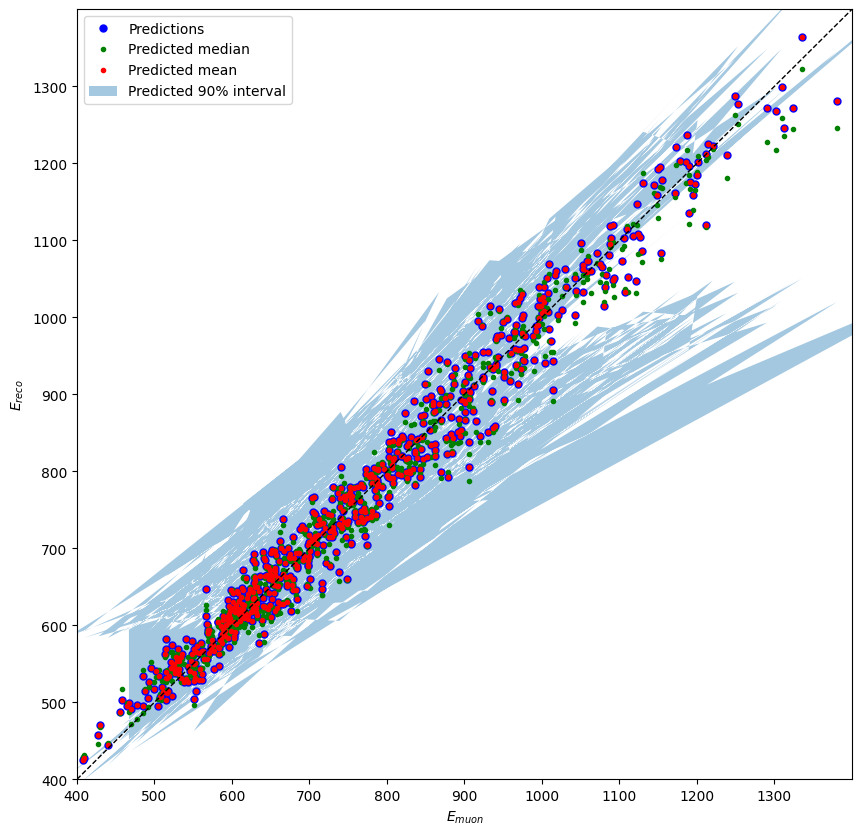

In [125]:
makeplots_result(y_test, y_pred, y_med, y_upper, y_lower)

In [ ]:
!pip freeze